In [6]:
%pip install numpy==1.24.4 --force-reinstall
%pip install transformers torch captum --upgrade

Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-1.24.4-cp39-cp39-macosx_11_0_arm64.whl (13.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.20.0 requires torch==2.5.0, but you have torch 2.7.0 which is incompatible.
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need

In [10]:
%pip uninstall -y torch torchvision
%pip install torch torchvision --index-url https://download.pytorch.org/whl/cpu

Found existing installation: torch 2.7.0
Uninstalling torch-2.7.0:
  Successfully uninstalled torch-2.7.0
Found existing installation: torchvision 0.20.0
Uninstalling torchvision-0.20.0:
  Successfully uninstalled torchvision-0.20.0
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cpu
     |████████████████████████████████| 68.6 MB 3.9 MB/s eta 0:00:013
     |████████████████████████████████| 1.9 MB 8.5 MB/s eta 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.5.0 requires torch==2.5.0, but you have torch 2.7.0 which is incompatible.
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restar

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_path = "./model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.eval()

OSError: ahmedheakl/resume-classification-gemma-2b-v1 does not appear to have a file named pytorch_model.bin, model.safetensors, tf_model.h5, model.ckpt or flax_model.msgpack.

In [3]:
# text imput
text = "Senior Java developer with 10+ years experience in backend systems, cloud, and microservices."

inputs = tokenizer(text, return_tensors="pt", padding=True)
input_ids = inputs["input_ids"]

# baseline of the same length
baseline_ids = tokenizer("", return_tensors="pt", padding="max_length", max_length=input_ids.shape[1])["input_ids"]

In [6]:
def forward_func(input_embeds):
    output = model(inputs_embeds=input_embeds)
    logits = output.logits
    return torch.softmax(logits, dim=1)[:, 1]  # например, класс "позитив"

In [7]:
# making embeddings
input_embeds = model.get_input_embeddings()(input_ids)
baseline_embeds = model.get_input_embeddings()(baseline_ids)

# integrated gradients
ig = IntegratedGradients(forward_func)
attributions, _ = ig.attribute(
    inputs=input_embeds,
    baselines=baseline_embeds,
    return_convergence_delta=True
)

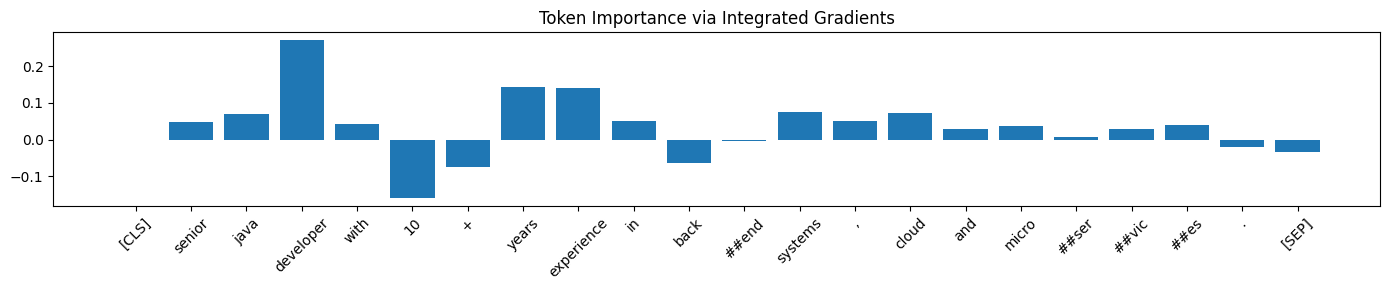

In [8]:
token_attributions = attributions.sum(dim=-1).squeeze().detach().numpy()
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

# drawing a graph
plt.figure(figsize=(14, 3))
plt.bar(tokens, token_attributions)
plt.xticks(rotation=45)
plt.title("Token Importance via Integrated Gradients")
plt.tight_layout()
plt.savefig("example1.png", bbox_inches='tight')
plt.show()